In [1]:
import sys; sys.path.append('/Users/omid/Documents/GitHub/Causality/Quantum_RCC/Scripts')
import numpy as np; np.set_printoptions(precision=3, suppress=True) 
import torch as th; import torch; from torch.utils.data import DataLoader; import torch.nn as nn; import torch.nn.functional as F
import pandas as pd; import networkx as nx
import matplotlib.pyplot as plt; import seaborn as sns; sns.set()
from pathlib import Path; import itertools; import os; import random; import time; import copy
import sklearn; from sklearn.model_selection import train_test_split; from sklearn.ensemble import RandomForestClassifier; from sklearn.neural_network import MLPClassifier
import scipy
import ast
import IPython
from sklearn.metrics import confusion_matrix

import rcc_functions as rcc
import utilities_functions as uFun
import channel_functions as chFun
import distance_functions as dFun
import simulator_functions as simFun

In [2]:
n_nodes = 8
n_points = 500

split_subsets = ['tr', 'va', 'te']
scenario = 'multi_8node'

In [3]:
#param_dict = generate_parameters(n_nodes)
#uFun.save_as_pickle(param_dict, 'param_dict.pickle')
param_dict = uFun.load_pickle(f'../../Data/ch_parameter/{scenario}/param_dict.pickle')

### Generate Channel Data

- 3-variate samples
- 8-variate samples

In [4]:
adjacencies_base = [
    th.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]), 
    th.tensor([[0, 1, 0], [0, 0, 0], [0, 0, 0]]), 
    th.tensor([[0, 1, 0], [0, 0, 1], [0, 0, 0]]), 
    th.tensor([[0, 1, 0], [0, 0, 0], [0, 1, 0]]), 
    th.tensor([[0, 0, 0], [1, 0, 1], [0, 0, 0]]), 
    th.tensor([[0, 1, 1], [0, 0, 1], [0, 0, 0]]), 
    th.tensor([[0, 1, 1], [0, 0, 0], [0, 1, 0]]), 
    th.tensor([[0, 0, 1], [1, 0, 1], [0, 0, 0]]),
]

##########################################################
# ch org multibase (3-variate samples)
##########################################################
n_samples = 2688
generator = chFun.genDataChannels(param_dict=param_dict)
container_d = th.zeros((n_samples, n_points, 3*3), dtype=th.float32)
container_a = th.zeros((n_samples, 3, 3), dtype=th.float32)
index_sample = 0
for i in range(n_nodes):
    for j in range(n_nodes):
        for k in range(n_nodes):
            if (i-j)*(j-k)*(k-i):
                for A_base in adjacencies_base:
                    adjacency_matrix = uFun.embed_graph(i, j, k, A_base, n_nodes)
                    #ch_data = simulator(n_points, adjacency_matrix).detach()
                    ch_data = generator.generate(adjacency_matrix=adjacency_matrix.numpy(), numRuns=n_points)
                    ch_data = th.concat((ch_data[:, 3*(i):3*(i+1)], ch_data[:, 3*(j):3*(j+1)], ch_data[:, 3*(k):3*(k+1)]), dim=1)
                    container_d[index_sample] = ch_data
                    container_a[index_sample] = A_base
                    index_sample += 1
                    print(index_sample)
ch_container = (container_d, container_a)
th.save(ch_container, f'../../Data/ch_container/{scenario}/org_ba.pt')


##########################################################
# ch org multi8node (8-variate samples)
##########################################################
generator = chFun.genDataChannels(param_dict=param_dict)
for subset in split_subsets:
    index_sample = 0
    container_a = th.tensor(np.array([A.reshape(8,8) for A in np.loadtxt(f'../../Data/DAGs/{scenario}/{subset}.txt')]).astype(int))
    n_samples = len(container_a)
    container_d = th.zeros((n_samples, n_points, 3*8), dtype=th.float32)
    for adjacency_matrix in container_a:
        ch_data = generator.generate(adjacency_matrix=adjacency_matrix.numpy(), numRuns=n_points)
        container_d[index_sample] = ch_data
        index_sample += 1
    ch_container = (container_d, container_a)
    th.save(ch_container, f'../../Data/ch_container/{scenario}/org_{subset}.pt')


### Fit a generative model (simulator) 

- Train on the 3-variate samples
- Validate on the training 8-variate samples 

In [5]:
simulator_path = f'../../Models/{scenario}/simulator_ijk'

simulator = simFun.nn_simulator(
    n_nodes=n_nodes, 
    batch_size=100, 
    n_epochs=1000,
    lr=1e-4,
    patience=100,
    dim_noise=20,
)
simulator.reset_parameters()

'''
df_prog = simulator.fit_ijk(
    data_tr=th.load(f'../../Data/ch_container/{scenario}/org_ba.pt'),
    data_va=th.load(f'../../Data/ch_container/{scenario}/org_va.pt'),
    list_ijk=uFun.get_list_ijk(n_nodes),
    saving_path=simulator_path,
)
'''
simulator.re_load(simulator_path)

nn_simulator(
  (criterion): MMDloss()
  (blocks_list): ModuleList(
    (0): NN_block(
      (layers): Sequential(
        (0): Linear(in_features=41, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (1): NN_block(
      (layers): Sequential(
        (0): Linear(in_features=41, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (2): NN_block(
      (layers): Sequential(
        (0): Linear(in_features=41, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (3): NN_block(
      (layers): Sequential(
        (0): Linear(in_features=41, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (4): NN_block(
      (layers): Sequential(
        (0): Linear(in_features=41, out_features=20, 

### Simulate Channel Data Using the Generative Model

- 8-variate samples


In [6]:
##########################################################
# ch sim multi8node (simulated 8-variate samples)
##########################################################
for subset in split_subsets:
    index_sample = 0
    container_a = th.tensor(np.array([A.reshape(8,8) for A in np.loadtxt(f'../../Data/DAGs/{scenario}/{subset}.txt')]).astype(int))
    n_samples = len(container_a)
    container_d = th.zeros((n_samples, n_points, 3*8), dtype=th.float32)
    for adjacency_matrix in container_a:
        ch_data = simulator(n_points, adjacency_matrix).detach()
        container_d[index_sample] = ch_data
        index_sample += 1
    ch_container = (container_d, container_a)
    th.save(ch_container, f'../../Data/ch_container/{scenario}/sim_{subset}.pt')


### Build Featurizer
A featuirizer object is used to compute the KME featurizer of given distributions

In [7]:
n_RandComps=50; data_dim=3; scales = list(np.logspace(-1.2, +1.2, 5, True))
featurizer_obj = rcc.featurizer(n_RandComps=n_RandComps, scales=scales, data_dim=data_dim)
#uFun.object_saver(featurizer_obj, 'featurizer')
featurizer_obj = uFun.object_loader(f'../../Models/{scenario}/kme_featurizer.pkl')

### Apply the Featurizer to Channel Data

- Convert all `ch_container` into `kme_container`

In [8]:
##########################################################
# kme org multibase (original 3-variate samples)
##########################################################
kme_container = rcc.kme_featurizer(
    ch_container_path = f'../../Data/ch_container/{scenario}/org_ba.pt', 
    featurizer_obj    = featurizer_obj, 
    scenario          = 'multi_base', 
    quad_labeling     = True,
    saving_path       = f'../../Data/kme_container/{scenario}/org_ba.pt',
)

##########################################################
# kme org multi8node (original 8-variate samples)
##########################################################
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = f'../../Data/ch_container/{scenario}/org_{subset}.pt', 
        featurizer_obj    = featurizer_obj, 
        scenario          = 'multi_8node', 
        quad_labeling     = True,
        saving_path       = f'../../Data/kme_container/{scenario}/org_{subset}.pt',
    )

##########################################################
# kme sim multi8node (simulated 3-variate samples)
##########################################################
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = f'../../Data/ch_container/{scenario}/sim_{subset}.pt', 
        featurizer_obj    = featurizer_obj, 
        scenario          = 'multi_8node', 
        quad_labeling     = True,
        saving_path       = f'../../Data/kme_container/{scenario}/sim_{subset}.pt',
    )

### Read KME Datasets

In [9]:
convert_dict = {1:0, 2:1, 0:2}

df_org_ba = rcc.container_to_df(
    f'../../Data/kme_container/{scenario}/org_ba.pt', 
    'multi_base', 
    return_unique=False,
)
df_org_tr = rcc.container_to_df(
    f'../../Data/kme_container/{scenario}/org_tr.pt',
    'multi_8node', 
    return_unique=True,
)
df_org_va = rcc.container_to_df(
    f'../../Data/kme_container/{scenario}/org_va.pt',
    'multi_8node', 
    return_unique=True,
)
df_org_te = rcc.container_to_df(
    f'../../Data/kme_container/{scenario}/org_te.pt',
    'multi_8node', 
    return_unique=True,
)
df_sim_tr = rcc.container_to_df(
    f'../../Data/kme_container/{scenario}/sim_tr.pt',
    'multi_8node', 
    return_unique=True,
)

df_tr = pd.concat([df_org_ba, df_sim_tr], axis=0)
df_va = df_org_va
df_te = df_org_te

x_tr, y_tr = df_tr.values[:, 2:], df_tr.values[:, 1]
x_va, y_va = df_va.values[:, 2:], df_va.values[:, 1]
x_te, y_te = df_te.values[:, 2:], df_te.values[:, 1]

x_tr, y_tr = th.tensor(x_tr), th.tensor(y_tr)
x_va, y_va = th.tensor(x_va), th.tensor(y_va)
x_te, y_te = th.tensor(x_te), th.tensor(y_te)

y_tr = y_tr.type(th.int64).apply_(lambda v: convert_dict.get(v))
y_va = y_va.type(th.int64).apply_(lambda v: convert_dict.get(v))
y_te = y_te.type(th.int64).apply_(lambda v: convert_dict.get(v))

### Train and Test CLF on KME Datasets

- data_tr = sim_tr + sim_tr
- data_va = org_va
- data_te = org_te

In [10]:
clf = MLPClassifier(
    hidden_layer_sizes=(150,100),  
    activation='tanh',
    solver='adam', 
    learning_rate_init=1e-4,
    validation_fraction=0.2, 
    #alpha=1e-2,
    #batch_size = 50,
    n_iter_no_change=20,
    early_stopping=True,
    max_iter=1000000,
    verbose=1,
).fit(x_tr, y_tr)
uFun.object_saver(clf, f'../../Models/{scenario}/causal_classifier')

In [31]:
clf = uFun.object_loader(f'../../Models/{scenario}/causal_classifier')
y_true = y_te.numpy()
y_pred = th.tensor(clf.predict(x_te)).apply_(lambda v: convert_dict.get(v))
confusion = confusion_matrix(y_true, y_pred, labels=[2, 1, 0], normalize='true')
print(confusion)

[[0.753 0.127 0.12 ]
 [0.113 0.783 0.104]
 [0.117 0.076 0.807]]


### Visualize Performance

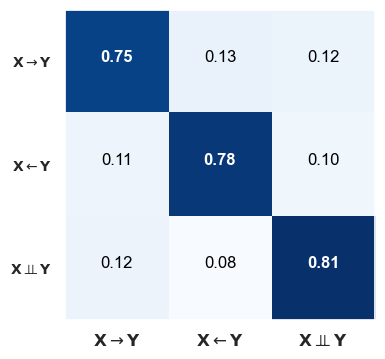

In [32]:
sns.set_style("dark")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), tight_layout=True)
uFun.plot_confusion(ax, confusion, [0, 1, 2,], fontsize=None)
plt.show()
plt.close()